In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import json
from sklearn.metrics import classification_report,f1_score
import numpy as np
from tqdm import tqdm
torch.manual_seed(1)

In [2]:
with open('data_processed/LR_train_tagged.json') as f: 
    LR_train_json = json.load(f)
    
with open('data_processed/LR_test_tagged.json') as f:
    LR_test_json = json.load(f)
    
with open('data_processed/LR_val_tagged.json') as f:
    LR_val_json = json.load(f)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(len(LR_train_json))

906


### fasttext

In [5]:
# fasttextmodel = FastText()
fasttext_file = 'Part2/.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

### Glove

In [ ]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = '../.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector

In [255]:
unique_labels = []

for entry in LR_train_json:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)
        
unique_labels=sorted(list(set(unique_labels)))
class_names = []
for ul in unique_labels:
    class_names.append(ul.replace("B_",'').replace("I_",''))
class_names = set(class_names)

### Helpers

In [6]:
## Helper Functions
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

def generate_tags_to_idx(data):
    START_TAG = "<START>"
    STOP_TAG = "<STOP>"
    unique_labels = []
    for entry in data:
        labels = entry['labels']
        for label in labels:
            unique_labels.append(label)
    unique_labels=sorted(list(set(unique_labels)))
    label_dict = {}
    for label_index in range(len(unique_labels)):
        label_dict[unique_labels[label_index]] = label_index
        
    label_dict[START_TAG]=len(label_dict)
    label_dict[STOP_TAG]=len(label_dict)
    
    output_dict = {}
    for key, value in label_dict.items():
        new_key = key.replace('B_', '').replace('I_', '')
        if new_key not in output_dict:
            output_dict[new_key] = len(output_dict)
    return output_dict

def get_embeds(sentence, embed_model, embedding_dim):
    word_vectors = []
    for word in sentence:
        # Check if the word exists in the Word2Vec model's vocabulary
        if word in embed_model:
            # Get the word vector for the current word
            word_vector = torch.tensor(embed_model[word], dtype=torch.float32)
            # Append the word vector to the list
            word_vectors.append(word_vector)
        else:
            # If the word is not in the vocabulary, append a zero vector
            word_vectors.append(torch.zeros(embedding_dim, dtype=torch.float32))

    # Convert the list of word vectors to a tensor
    embeds_tensor = torch.stack(word_vectors).to(device)

    return embeds_tensor

In [7]:
#need to remove embedding layer
class BiLSTM_CRF(nn.Module):
    def __init__(self, tag_to_ix, embedding_model, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        START_TAG = "<START>"
        STOP_TAG = "<STOP>"
        self.embed_model=embedding_model
        self.embedding_dim=len(embedding_model['hello'])
        self.hidden_dim = hidden_dim
        # self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        # do not need this we use glovemodel output
        # self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size).to(device))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        START_TAG = "<START>"
        STOP_TAG = "<STOP>"
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1).to(device)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = tuple(h.to(device) for h in self.init_hidden())
        # self.hidden.to(device)
        # embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embeds=sentence.unsqueeze(1)
        embeds=embeds.to(torch.float32).to(device)
        # print(embeds)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        START_TAG = "<START>"
        STOP_TAG = "<STOP>"
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags]).to(device)
        # print(feats.shape)
        # print(tags)
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        START_TAG = "<START>"
        STOP_TAG = "<STOP>"
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        feats.to(device)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

### Model Declaration

In [8]:
HIDDEN_DIM = 32
tag_to_ix=generate_tags_to_idx(LR_train_json)
vocab_size=len(fastmodel['hello'])
model = BiLSTM_CRF(tag_to_ix, fastmodel, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

In [9]:
tag_to_ix

{'B': 0, 'I': 1, 'O': 2, '<START>': 3, '<STOP>': 4}

### Train loop

In [10]:
def train(model,optimizer,epochs,train_data, validation_data, tags = tag_to_ix):
    train_f1_scores = []
    train_losses = []
    val_f1_scores = []
    val_losses = []
    
    tag_to_ix=tags
    model.to(device) 
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []
        print(epoch)
        for i in tqdm(range(len(train_data))):
            entry=train_data[i]
            sentence=entry['text'].split()
            tags=entry['labels']
            new_tags = []
            for tag in tags:
                new_tag= tag.replace('B_', '').replace('I_', '')
                new_tags.append(new_tag)
            optimizer.zero_grad()
            sentence_in = get_embeds(sentence,fastmodel,300)
            targets = torch.tensor([tag_to_ix[t] for t in new_tags], dtype=torch.long).to(device)
            _ , predicted = model(sentence_in)

            loss = model.neg_log_likelihood(sentence_in, targets)
            train_loss += loss.item()
            all_train_labels.extend(targets.cpu().numpy())
            all_train_preds.extend(predicted)
            loss.backward()
            optimizer.step()
            
        epoch_f1_score = f1_score(all_train_labels, all_train_preds, average='macro')
        epoch_loss = train_loss / len(train_data) 
        train_f1_scores.append(epoch_f1_score)
        train_losses.append(epoch_loss)
        
        print('Train Loss: {:.4f}'.format(epoch_loss))
        print('Train F1 Score: {:.4f}'.format(epoch_f1_score))
        


        model.eval()
        with torch.no_grad():
            for j in tqdm(range(len(validation_data))):
                entry=train_data[i]
                sentence=entry['text'].split()
                tags=entry['labels']
                new_tags = []
                for tag in tags:
                    new_tag= tag.replace('B_', '').replace('I_', '')
                    new_tags.append(new_tag)
                sentence_in = get_embeds(sentence,fastmodel,300)
                targets = torch.tensor([tag_to_ix[t] for t in new_tags], dtype=torch.long).to(device)
                _, predicted = model(sentence_in)
                loss = model.neg_log_likelihood(sentence_in, targets)
                val_loss += loss.item()
                all_val_labels.extend(targets.cpu().numpy())
                all_val_preds.extend(predicted)
            
            epoch_f1_score = f1_score(all_val_labels, all_val_preds, average='macro')
            epoch_loss = val_loss / len(validation_data)
            
            val_f1_scores.append(epoch_f1_score)
            val_losses.append(epoch_loss)

            print('Validation Loss: {:.4f}'.format(epoch_loss))
            print('Validation F1 Score: {:.4f}'.format(epoch_f1_score))
            
    return train_losses,val_losses,train_f1_scores,val_f1_scores

### Losses

In [11]:
train_losses,val_losses,train_f1_scores,val_f1_scores = train(model,optimizer=optimizer,epochs=5,train_data=LR_train_json, validation_data=LR_val_json,tags = tag_to_ix)

0


100%|██████████| 906/906 [01:25<00:00, 10.64it/s]


Train Loss: 5.2816
Train F1 Score: 0.5123


100%|██████████| 906/906 [00:48<00:00, 18.58it/s]


Validation Loss: 4.2014
Validation F1 Score: 0.3169
1


100%|██████████| 906/906 [01:19<00:00, 11.35it/s]


Train Loss: 3.2437
Train F1 Score: 0.6811


100%|██████████| 906/906 [00:49<00:00, 18.40it/s]


Validation Loss: 4.2753
Validation F1 Score: 0.3158
2


100%|██████████| 906/906 [01:23<00:00, 10.87it/s]


Train Loss: 2.8441
Train F1 Score: 0.7243


100%|██████████| 906/906 [00:48<00:00, 18.75it/s]


Validation Loss: 4.0365
Validation F1 Score: 0.3158
3


100%|██████████| 906/906 [01:23<00:00, 10.80it/s]


Train Loss: 2.5942
Train F1 Score: 0.7431


100%|██████████| 906/906 [00:51<00:00, 17.67it/s]


Validation Loss: 3.7251
Validation F1 Score: 0.3160
4


100%|██████████| 906/906 [01:26<00:00, 10.51it/s]


Train Loss: 2.4317
Train F1 Score: 0.7540


100%|██████████| 906/906 [00:48<00:00, 18.82it/s]


Validation Loss: 3.4256
Validation F1 Score: 0.3170


### Saving Model

In [12]:
torch.save(model.state_dict(),"trained_models/t2_bilstm_fasttext.pth")

# Plots


In [13]:
import seaborn as sns

[Text(0.5, 1.0, 'Train and Validation Losses'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss')]

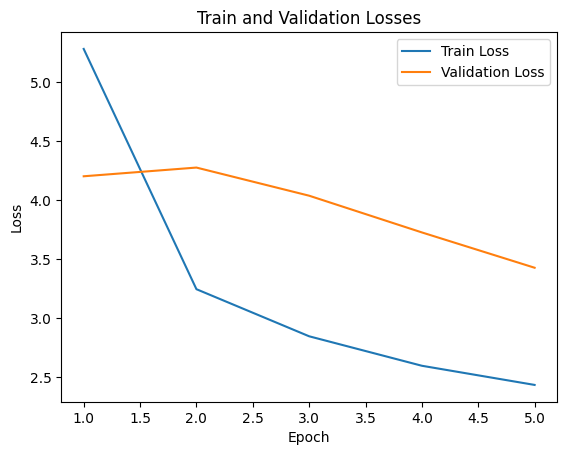

In [15]:
sns.lineplot(x=range(1, 6), y=train_losses, label="Train Loss").set(title="Train and Validation Losses", xlabel="Epoch", ylabel="Loss")
sns.lineplot(x=range(1, 6), y=val_losses, label="Validation Loss").set(title="Train and Validation Losses", xlabel="Epoch", ylabel="Loss")

[Text(0.5, 1.0, 'Train and Validation F1 Scores'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'F1 Score')]

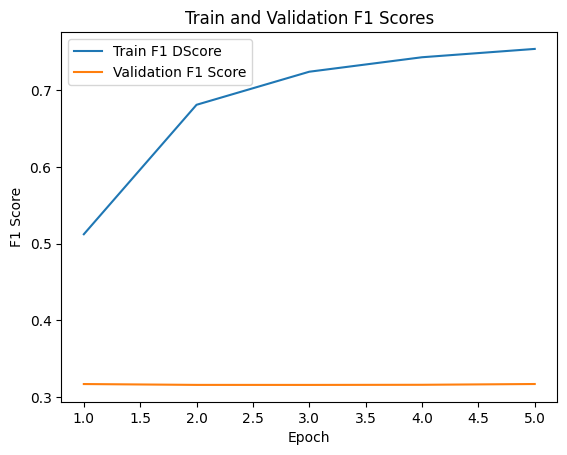

In [16]:
sns.lineplot(x=range(1, 6), y=train_f1_scores, label="Train F1 DScore ").set(title="Train and Validation F1 Scores", xlabel="Epoch", ylabel="F1 Score")
sns.lineplot(x=range(1, 6), y=val_f1_scores, label="Validation F1 Score").set(title="Train and Validation F1 Scores", xlabel="Epoch", ylabel="F1 Score")

In [23]:
from sklearn.metrics import f1_score

def test(model, test_data,count, tag_dict = tag_to_ix):
    true_labels = []
    predicted_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available
    with torch.no_grad():
        cnt=0
        for entry in test_data:
            try:
                cnt+=1
                if cnt>count:
                    break
                # Step 1. Get the inputs ready for the network
                sentence=entry['text'].split()
                tags=entry['labels']
                new_tags = []
                for tag in tags:
                    new_tag= tag.replace('B_', '').replace('I_', '')
                    new_tags.append(new_tag)

                sentence_in = get_embeds(sentence,fastmodel,300)
                targets = torch.tensor([tag_dict[t] for t in new_tags], dtype=torch.long)

                # Step 2. Run the forward pass
                _, predicted_tags = model(sentence_in)

                # Convert predicted tags tensor to a list
                predicted_tags = predicted_tags

                # Append true and predicted labels for F1 score calculation
                true_labels.extend(targets.tolist())
                predicted_labels.extend(predicted_tags)
            except:
                continue

    # Calculate F1 scores for each class
    f1 = f1_score(true_labels, predicted_labels, average = "macro")
    print("Macro F1 Score:{f1s}".format(f1s = f1))
    report = classification_report(true_labels, predicted_labels,  target_names= ['B','I','O'])
    print(report)

In [24]:
test(model,LR_test_json,np.inf,tag_dict = tag_to_ix)

Macro F1 Score:0.7634503998053299
              precision    recall  f1-score   support

           B       0.68      0.75      0.71      1281
           I       0.52      0.75      0.61       584
           O       0.98      0.95      0.96     15489

    accuracy                           0.93     17354
   macro avg       0.72      0.82      0.76     17354
weighted avg       0.94      0.93      0.93     17354



In [22]:
tag_to_ix.keys()

dict_keys(['B', 'I', 'O', '<START>', '<STOP>'])